In [64]:
library(dbscan)
library(ggplot2)
library(MASS)
library(FactoMineR)
library(repr)
library(scatterplot3d)
library(uwot)

In [2]:
options(repr.plot.width=4, repr.plot.height=3)

## Using KNN instead of all distances

In [65]:
# Compute t-SNE probability score matrix. #
# Args:
# X: A numeric data matrix.
# perplexity: Desired perplexity score for all variables. #
# Returns:
# A matrix of probability densities.
casl_tsne_p <- function(X, perplexity=15)
    {
    #D <- as.matrix(dist(X))^2
    #D <- matrix(0, nrow(X), nrow(X)) 
    Kdist <- kNN(X, k=2*perplexity, approx=1)
    #print(Kdist$id)
    Kdist_idx <- Kdist$id
    Kdist_D <- Kdist$dist
    #print(Kdist_D)
    #print(Kdist_idx)
    P <- matrix(0, nrow(X), nrow(X)) 
    #svals <- rep(1, nrow(X)) #non-adaptive sigma values
    svals = as.array(Kdist_D[,perplexity])
    for (i in seq_along(svals)) {
        idx = Kdist_idx[i,]
        srange <- c(0, 100)
        #Find P_j|i and adapt sigma
        for(j in seq_len(50)) {
            #Pji <- exp(-D[i, -i] / (2 * svals[i]))  
            Pji <- exp(- Kdist_D[i,] / (2 * svals[i])) 
            Pji <- Pji / sum(Pji) #normalize P_j|i
            H <- -1 * Pji %*% log(Pji, 2)
            if (H < log(perplexity, 2)){ #adapting sigma
                srange[1] <- svals[i] + 0.01
                svals[i] <- (svals[i] + srange[2]) / 2
                }
            else {
                srange[2] <- svals[i] + 0.01
                svals[i] <- (svals[i] + srange[1]) / 2
                } 
            }
        #P[i, -i] <- Pji
        P[i, idx] <- Pji #saving the P_j|i values
        }
    #returning (P_j|i + P_i|j)/2n
    print(svals)
    return(0.5 * (P + t(P)) / sum(P)) 

    }

In [48]:
# Compute t-SNE probability score matrix. #
# Args:
# X: A numeric data matrix.
# perplexity: Desired perplexity score for all variables. #
# Returns:
# A matrix of probability densities.
casl_tsne_p <- function(X, perplexity=15)
    {
    #D <- as.matrix(dist(X))^2
    #D <- matrix(0, nrow(X), nrow(X)) 
    print("---KNN calculation")
    Kdist <- kNN(X, k=2*perplexity, approx=1)
    #print(Kdist$id)
    Kdist_idx <- Kdist$id
    Kdist_D <- Kdist$dist
    #print(Kdist_D)
    #print(Kdist_idx)
    P <- matrix(0, nrow(X), nrow(X)) 
    #svals <- rep(1, nrow(X)) #non-adaptive sigma values
    svals = rep(as.array(Kdist_D[,perplexity]), ncol(Kdist_D))
    svals_m = matrix(svals, nrow=nrow(Kdist_D))
    print("---P matrix calculation")
    print(dim(Kdist_D))
    print(dim(svals_m))
    Pji = exp(- Kdist_D / (2 * svals_m))
    Pji = t(apply(Pji, 1, function(x) x/sum(x)))
    print( dim(Pji) )
    print(dim(P[, Kdist_idx]))
    for(i in nrow(Kdist_D))    
        P[i, Kdist_idx[i,]] <- Pji[i,]
    #print(P)              
    #for (i in seq_along(svals)) {
    #    idx = Kdist_idx[i,]
    #    srange <- c(0, 100)
        #Find P_j|i and adapt sigma

    #    Pji <- exp(- Kdist_D[i,] / (2 * svals[i])) 
    #    Pji <- Pji / sum(Pji) #normalize P_j|i
        #P[i, -i] <- Pji
    #    P[i, idx] <- Pji #saving the P_j|i values
    #    }
    #returning (P_j|i + P_i|j)/2n
    
    return(0.5 * (P + t(P)) / sum(P)) 

    }

In [37]:
x=matrix(rep(c(1,2,3,4),3),nrow=4)

In [42]:
x

1,1,1
2,2,2
3,3,3
4,4,4


In [43]:
apply(x,1,function(x) t(x/sum(x)))

0.3333333,0.3333333,0.3333333,0.3333333
0.3333333,0.3333333,0.3333333,0.3333333
0.3333333,0.3333333,0.3333333,0.3333333


In [104]:
# Compute t-SNE embeddings. #
# Args:
# X: A numeric data matrix.
# perplexity: Desired perplexity score for all variables.
# k: Dimensionality of the output.
# iter: Number of iterations to perform.
# rho: A positive numeric learning rate. #
# Returns:
# An nrow(X) by k matrix of t-SNE embeddings.

casl_tsne <- function(X, 
                      init=FALSE, 
                      perplexity=30, 
                      label_column = "labels",
                      plotting=list(epochs=10, 
                                    folder=paste("figure_",gsub(' ','-',as.character(Sys.time())),sep="")),
                      k=2L, iter=1000L, rho=100) {
    
    labels <- X[[label_column]]
    print(labels)
    X = X[,!names(X) %in% c(label_column)]
    
    #possibility of initialization of projection
    if(!is.matrix(init))
        Y <- matrix(rnorm(nrow(X) * k), ncol = k)
    else
        Y <- init
    
    if(is.list(plotting))
        dir.create(plotting$folder, showWarnings = FALSE)
        
    P <- casl_tsne_p(X, perplexity) 
    del <- matrix(0, nrow(Y), ncol(Y))
    
    pdf_counter <- 1
    for (inum in seq_len(iter)) {
        
        if(is.list(plotting)){
            if(inum %% plotting$epochs == 0){
                file_name <- paste(plotting$folder,"/plot_",as.character(pdf_counter),".pdf",sep="")
                Y_plot <- as.data.frame(Y)
                colnames(Y_plot) <- c("tSNE1","tSNE2")
                Y_plot$label_column <- labels
                print(head(Y_plot))
                ggplot(Y_plot, aes(x=tSNE1, y=tSNE2, color=factor(labels))) +
                geom_point() + 
                scale_fill_discrete(drop=FALSE) +
                theme(legend.position="top")
                ggsave(filename = file_name, width = 20, height = 20, units = "cm")
                pdf_counter <- pdf_counter + 1
                }
            }
            
        
        num <- matrix(0, nrow(X), nrow(X))
        for (j in seq_len(nrow(X))) { 
            for (k in seq_len(nrow(X))) {
                num[j, k] = 1 / (1 + sum((Y[j,] - Y[k, ])^2)) 
            }
        }
    diag(num) <- 0
    Q <- num / sum(num)
    stiffnesses <- 4 * (P - Q) * num 
    for (i in seq_len(nrow(X)))
        del[i, ] <- stiffnesses[i, ] %*% t(Y[i, ] - t(Y))
    Y <- Y - rho * del
    Y <- t(t(Y) - apply(Y, 2, mean)) 
    }
return(Y)  
}

In [127]:
# Compute t-SNE embeddings. #
# Args:
# X: A numeric data matrix.
# perplexity: Desired perplexity score for all variables.
# k: Dimensionality of the output.
# iter: Number of iterations to perform.
# rho: A positive numeric learning rate. #
# Returns:
# An nrow(X) by k matrix of t-SNE embeddings.

casl_tsne <- function(X, init=FALSE, perplexity=30, momentum=list(init=.5, final=.9, iter=200L), k=2L, iter=1000L, rho=100) {
    
    #momentum variables
    mom_init = momentum$init
    mom_final = momentum$final
    mom_iter = momentum$iter
    mom_select <- function(i){ return(ifelse(i<mom_iter, mom_init, mom_final)) }
    
    #possibility of initialization of projection
    if(!is.matrix(init))
        Y <- matrix(rnorm(nrow(X) * k), ncol = k)
    else
        Y <- init
    
    Y_old <- list()
    Y_old[[1]] <- Y
    Y_old[[2]] <- Y
    
    P <- casl_tsne_p(X, perplexity) 
    del <- matrix(0, nrow(Y), ncol(Y))
    for (inum in seq_len(iter)) {
        num <- matrix(0, nrow(X), nrow(X))
        for (j in seq_len(nrow(X))) { 
            for (k in seq_len(nrow(X))) {
                num[j, k] = 1 / (1 + sum((Y[j,] - Y[k, ])^2)) 
            }
        }
    diag(num) <- 0
    Q <- num / sum(num)
    stiffnesses <- 4 * (P - Q) * num 
    for (i in seq_len(nrow(X))){
        del[i, ] <- stiffnesses[i, ] %*% t(Y[i, ] - t(Y))
    }
        
    Y_old[[ inum%%2+1 ]] <- Y     
    Y <- Y - rho * del + mom_select(inum)*(Y_old[[2]] - Y_old[[1]])
        
    Y <- t(t(Y) - apply(Y, 2, mean)) 
    }
return(Y)  
}

In [26]:
# Compute t-SNE embeddings. #
# Args:
# X: A numeric data matrix.
# perplexity: Desired perplexity score for all variables.
# k: Dimensionality of the output.
# iter: Number of iterations to perform.
# rho: A positive numeric learning rate. #
# Returns:
# An nrow(X) by k matrix of t-SNE embeddings.

casl_tsne <- function(X, init=FALSE, 
                      perplexity=30, 
                      momentum=list(init=.5, final=.9, iter=200L),
                      early_ex=list(factor=12, iter=200L),
                      k=2L, iter=1000L, rho=100) {
    
    #momentum variables
    mom_init = momentum$init
    mom_final = momentum$final
    mom_iter = momentum$iter
    mom_select <- function(i){ return(ifelse(i<mom_iter, mom_init, mom_final)) }
    #early exaggeration variables
    ee_factor <- early_ex$factor
    ee_iter <- early_ex$iter
    ee_select <- function(i){ return(ifelse(i<ee_iter, ee_factor, 1)) }
   
    
    #possibility of initialization of projection
    if(!is.matrix(init))
        Y <- matrix(rnorm(nrow(X) * k), ncol = k)
    else
        Y <- init
    
    Y_old <- list()
    Y_old[[1]] <- Y
    Y_old[[2]] <- Y
    
    P <- casl_tsne_p(X, perplexity) 
    del <- matrix(0, nrow(Y), ncol(Y))
    for (inum in seq_len(iter)) {
        num <- matrix(0, nrow(X), nrow(X))
        for (j in seq_len(nrow(X))) { 
            for (k in seq_len(nrow(X))) {
                num[j, k] = 1 / (1 + sum((Y[j,] - Y[k, ])^2)) 
            }
        }
    diag(num) <- 0
    Q <- num / sum(num)
    stiffnesses <- 4 * (ee_select(inum)*P - Q) * num 
    for (i in seq_len(nrow(X))){
        del[i, ] <- stiffnesses[i, ] %*% t(Y[i, ] - t(Y))
    }
        
    Y_old[[ inum%%2+1 ]] <- Y    
        
    Y <- Y - rho/ee_select(inum) * del + mom_select(inum)*(Y_old[[2]] - Y_old[[1]])
        
    Y <- t(t(Y) - apply(Y, 2, mean)) 
    }
return(Y)  
}

In [66]:
# Compute t-SNE embeddings. #
# Args:
# X: A numeric data matrix.
# perplexity: Desired perplexity score for all variables.
# k: Dimensionality of the output.
# iter: Number of iterations to perform.
# rho: A positive numeric learning rate. #
# Returns:
# An nrow(X) by k matrix of t-SNE embeddings.

casl_tsne <- function(X, init=FALSE, 
                      perplexity=30, 
                      momentum=list(init=.5, final=.9, iter=200L),
                      early_ex=list(factor=12, iter=200L),
                      eps_stop=0.00001,
                      k=2L, iter=1000L, rho=100) {
    
    #momentum variables
    mom_init = momentum$init
    mom_final = momentum$final
    mom_iter = momentum$iter
    mom_select <- function(i){ return(ifelse(i<mom_iter, mom_init, mom_final)) }
    #early exaggeration variables
    ee_factor <- early_ex$factor
    ee_iter <- early_ex$iter
    ee_select <- function(i){ return(ifelse(i<ee_iter, ee_factor, 1)) }
   
    
    #possibility of initialization of projection
    if(!is.matrix(init))
        Y <- matrix(rnorm(nrow(X) * k), ncol = k)
    else
        Y <- init
    
    Y_old <- list()
    Y_old[[1]] <- Y
    Y_old[[2]] <- Y
    
    P <- casl_tsne_p(X, perplexity) 
    del <- matrix(0, nrow(Y), ncol(Y))
    for (inum in seq_len(iter)) {
        num <- matrix(0, nrow(X), nrow(X))
        for (j in seq_len(nrow(X))) { 
            for (k in seq_len(nrow(X))) {
                num[j, k] = 1 / (1 + sum((Y[j,] - Y[k, ])^2)) 
            }
        }
    diag(num) <- 0
    Q <- num / sum(num)
    stiffnesses <- 4 * (ee_select(inum)*P - Q) * num 
    for (i in seq_len(nrow(X))){
        del[i, ] <- stiffnesses[i, ] %*% t(Y[i, ] - t(Y))
    }
        
    Y_old[[ inum%%2+1 ]] <- Y    
        
    Y <- Y - rho/ee_select(inum) * del + mom_select(inum)*(Y_old[[2]] - Y_old[[1]])
        
    Y <- t(t(Y) - apply(Y, 2, mean)) 
    if(norm( Y-Y_old[[ 1 ]],"2") / norm(Y_old[[ 1 ]]+.001), "2") < eps_stop){
        cat("Stop at ",inum," iterations\n",sep="")
        return(Y)
        }
    }
return(Y)  
}

In [5]:
t = read.table("Data/mnist/mnist_train.csv", sep=",", header=T)

In [6]:
head(t)

,label,X1x1,X1x2,X1x3,X1x4,X1x5,X1x6,X1x7,X1x8,X1x9,⋯,X28x19,X28x20,X28x21,X28x22,X28x23,X28x24,X28x25,X28x26,X28x27,X28x28
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,5,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
5,9,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
6,2,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [7]:
X <- t[, !(colnames(t) %in% c("label"))]

In [8]:
labels <- t[['label']]

In [9]:
labels

[1] 5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9 4 0 9 1 1 2 4 3 2 7 3 8 6 9 0 5
   [37] 6 0 7 6 1 8 7 9 3 9 8 5 9 3 3 0 7 4 9 8 0 9 4 1 4 4 6 0 4 5 6 1 0 0 1 7
   [73] 1 6 3 0 2 1 1 7 9 0 2 6 7 8 3 9 0 4 6 7 4 6 8 0 7 8 3 1 5 7 1 7 1 1 6 3
  [109] 0 2 9 3 1 1 0 4 9 2 0 0 2 0 2 7 1 8 6 4 1 6 3 4 5 9 1 3 3 8 5 4 7 7 4 2
  [145] 8 5 8 6 7 3 4 6 1 9 9 6 0 3 7 2 8 2 9 4 4 6 4 9 7 0 9 2 9 5 1 5 9 1 2 3
  [181] 2 3 5 9 1 7 6 2 8 2 2 5 0 7 4 9 7 8 3 2 1 1 8 3 6 1 0 3 1 0 0 1 7 2 7 3
  [217] 0 4 6 5 2 6 4 7 1 8 9 9 3 0 7 1 0 2 0 3 5 4 6 5 8 6 3 7 5 8 0 9 1 0 3 1
  [253] 2 2 3 3 6 4 7 5 0 6 2 7 9 8 5 9 2 1 1 4 4 5 6 4 1 2 5 3 9 3 9 0 5 9 6 5
  [289] 7 4 1 3 4 0 4 8 0 4 3 6 8 7 6 0 9 7 5 7 2 1 1 6 8 9 4 1 5 2 2 9 0 3 9 6
  [325] 7 2 0 3 5 4 3 6 5 8 9 5 4 7 4 2 7 3 4 8 9 1 9 2 8 7 9 1 8 7 4 1 3 1 1 0
  [361] 2 3 9 4 9 2 1 6 8 4 7 7 4 4 9 2 5 7 2 4 4 2 1 9 7 2 8 7 6 9 2 2 3 8 1 6
  [397] 5 1 1 0 2 6 4 5 8 3 1 5 1 9 2 7 4 4 4 8 1 5 8 9 5 6 7 9 9 3 7 0 9 0 6 6
  [433] 2 3 9 0 7 5 4 8 0 9 4 1 2 8 7 1 2 6 1 0 3 0 1 1 8 2 0 3 9 4 0 5 0 6 1 7
  [469] 7 8 1 9 2 0 5 1 2 2 7 3 5 4 9 7 1 8 3 9 6 0 3 1 1 2 6 3 5 7 6 8 3 9 5 8
  [505] 5 7 6 1 1 3 1 7 5 5 5 2 5 8 7 0 9 7 7 5 0 9 0 0 8 9 2 4 8 1 6 1 6 5 1 8
  [541] 3 4 0 5 5 8 3 6 2 3 9 2 1 1 5 2 1 3 2 8 7 3 7 2 4 6 9 7 2 4 2 8 1 1 3 8
  [577] 4 0 6 5 9 3 0 9 2 4 7 1 2 9 4 2 6 1 8 9 0 6 6 7 9 9 8 0 1 4 4 6 7 1 5 7
  [613] 0 3 5 8 4 7 1 2 5 9 5 6 7 5 9 8 8 3 6 9 7 0 7 5 7 1 1 0 7 9 2 3 7 3 2 4
  [649] 1 6 2 7 5 5 7 4 0 2 6 3 6 4 0 4 2 6 0 0 0 0 3 1 6 2 2 3 1 4 1 5 4 6 4 7
  [685] 2 8 7 9 2 0 5 1 4 2 8 3 2 4 1 5 4 6 0 7 9 8 4 9 8 0 1 1 0 2 2 3 2 4 4 5
  [721] 8 6 5 7 7 8 8 9 7 4 7 3 2 0 8 6 8 6 1 6 8 9 4 0 9 0 4 1 5 4 7 5 3 7 4 9
  [757] 8 5 8 6 3 8 6 9 9 1 8 3 5 8 6 5 9 7 2 5 0 8 5 1 1 0 9 1 8 6 7 0 9 3 0 8
  [793] 8 9 6 7 8 4 7 5 9 2 6 7 4 5 9 2 3 1 6 3 9 2 2 5 6 8 0 7 7 1 9 8 7 0 9 9
  [829] 4 6 2 8 5 1 4 1 5 5 1 7 3 6 4 3 2 5 6 4 4 0 4 4 6 7 2 4 3 3 8 0 0 3 2 2
  [865] 9 8 2 3 7 0 1 1 0 2 3 3 8 4 3 5 7 6 4 7 7 8 5 9 7 0 3 1 6 2 4 3 4 4 7 5
  [901] 9 6 9 0 7 1 4 2 7 3 6 7 5 8 4 5 5 2 7 1 1 5 6 8 5 8 4 0 7 9 9 2 9 7 7 8
  [937] 7 4 2 6 9 1 7 0 6 4 2 5 7 0 7 1 0 3 7 6 5 0 6 1 5 1 7 8 5 0 3 4 7 7 5 7
  [973] 8 6 9 3 8 6 1 0 9 7 1 3 0 5 6 4 4 2 4 4 3 1 7 7 6 0 3 6 0 7 1 1 4 9 4 3
 [1009] 4 8 2 2 1 8 7 0 8 1 0 7 6 3 7 7 5 8 8 9 0 0 4 1 5 2 2 3 9 4 9 5 0 6 7 7
 [1045] 1 8 0 2 2 0 4 1 1 2 7 3 9 7 2 8 1 9 5 8 8 1 9 8 3 1 6 5 7 4 2 7 0 3 0 4
 [1081] 1 1 7 9 1 1 8 5 7 5 0 6 6 0 4 1 2 3 4 4 6 8 0 9 5 8 7 0 3 5 4 5 9 6 7 1
 [1117] 9 6 1 3 8 3 9 1 2 7 7 7 0 2 3 1 1 4 2 5 6 0 9 6 2 8 9 2 3 3 6 9 1 4 3 3
 [1153] 0 7 7 1 7 7 3 6 4 9 5 4 4 2 7 9 0 9 8 4 4 9 1 2 4 9 3 0 4 1 6 2 6 3 7 4
 [1189] 2 6 6 7 1 8 9 0 4 1 4 2 1 3 6 4 6 7 5 8 7 0 5 1 4 2 8 4 7 7 3 8 4 9 5 8
 [1225] 6 7 3 4 6 7 1 7 4 3 3 9 8 8 1 8 6 3 1 1 3 5 2 8 4 2 9 7 1 4 8 2 9 6 4 1
 [1261] 3 4 2 5 2 5 6 8 0 6 2 4 9 4 9 4 5 1 5 8 4 7 9 5 9 5 9 1 5 8 3 9 9 1 8 3
 [1297] 8 6 5 2 7 2 7 6 0 9 7 9 4 6 0 5 3 5 7 3 9 3 6 8 3 1 7 6 5 5 7 6 5 8 2 1
 [1333] 7 9 2 7 3 6 7 8 5 3 7 7 8 4 0 7 3 0 6 3 9 7 1 9 5 3 6 0 9 2 8 0 9 1 6 0
 [1369] 0 1 9 0 0 4 2 1 7 0 3 4 4 7 5 9 8 2 0 0 8 6 2 2 7 6 1 2 9 2 6 9 7 9 5 0
 [1405] 8 1 5 2 4 3 9 4 7 5 6 6 7 7 6 8 5 9 7 0 6 1 9 2 3 3 5 4 3 5 8 6 3 7 2 8
 [1441] 4 9 5 0 2 1 4 2 4 3 1 7 1 8 0 9 6 8 1 9 4 4 9 1 8 9 6 5 5 3 3 0 1 4 3 8
 [1477] 3 4 2 0 7 5 5 1 8 5 3 4 6 0 5 7 2 6 6 0 1 1 4 7 9 0 0 6 6 8 6 9 4 5 2 4
 [1513] 0 7 5 6 5 0 9 8 6 1 9 7 5 7 5 1 1 3 0 2 0 3 8 1 6 4 6 2 6 4 8 8 1 4 4 7
 [1549] 1 2 2 3 9 6 4 9 5 6 2 3 9 2 6 2 7 4 3 6 4 9 7 0 2 2 9 5 4 5 0 1 4 3 6 3
 [1585] 2 9 7 5 3 7 0 9 5 8 3 2 0 1 8 3 0 1 2 3 4 0 0 1 7 2 9 3 9 4 2 5 8 6 7 7
 [1621] 9 8 9 9 2 0 0 1 4 2 4 3 9 4 3 5 7 6 5 7 1 8 6 9 3 0 4 1 2 2 5 3 7 4 1 7
 [1657] 7 8 1 9 2 3 2 4 0 1 8 4 3 6 5 6 4 7 9 3 1 3 0 2 1 1 0 9 9 4 6 7 6 3 5 5
 [1693] 4 4 6 9 1 1 3 1 1 0 5 1 4 4 6 6 6 0 1 2 0 8 2 2 1 1 3 7 9 5 3 0 2 0 6 2
 [1729] 9 0 7 6 9 9 1 2 9 3 4 7 9 6 0 9 4 8 7 7 9 8 6 9 5 2 2 2 3 9 8 8 8 6 4 4
 [1765] 4 4 2 4 6 0 7 0 7 8 2 0 8 8 3 6 8 6 6 8 6 5 1 1 8 7 8 3 6 8 9 5 0 0 0 3
 [18

In [10]:
PCA = PCA(X, ncp = 20)

In [11]:
Y_PCA = as.data.frame(PCA$ind$coord)

In [12]:
Y_PCA["labels"] <- factor(labels)

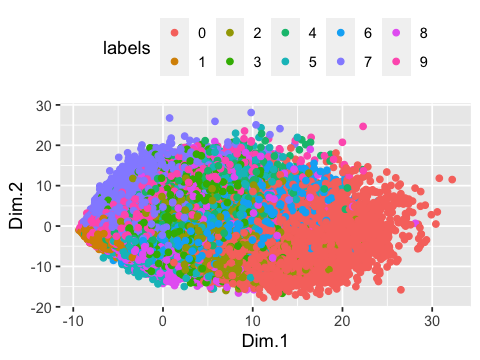

In [13]:
ggplot(Y_PCA, aes(x=Dim.1, y=Dim.2, color=labels)) +
  geom_point() +
  scale_fill_brewer(palette = "Set1") +
  theme(legend.position="top")

In [14]:
#X_std = apply(X, 2, function(x){(x-mean(x))/sd(x)})

In [68]:
PCA_sub <- Y_PCA[sample(x=1:10000,size = 100,replace = F),]

In [69]:
PCA <- PCA_sub[, !(colnames(PCA_sub) %in% c("labels"))]

In [105]:
Y_tsne <- casl_tsne(PCA_sub, 
                    #init = Y_PCA[c("Dim.1","Dim.2")], 
                    perplexity = 30, rho=100, iter=10000)

  [1] 0 4 7 5 7 2 2 6 4 6 3 7 2 2 4 1 0 6 9 5 1 3 6 4 0 8 9 5 4 9 9 3 1 3 8 6 2
 [38] 3 3 6 2 6 9 1 4 3 5 9 1 4 3 4 5 3 5 9 9 1 3 3 0 5 2 0 4 7 1 3 9 5 1 7 9 5
 [75] 1 7 6 1 5 0 9 7 4 3 3 0 1 9 4 2 8 2 1 9 1 9 2 4 7 5
Levels: 0 1 2 3 4 5 6 7 8 9
     7649      4830      3080      7999      5301      9250      5625      2864 
1.6738094 1.2398560 1.3751945 1.1068914 1.8007541 1.2609118 1.2302732 1.3381964 
     8062      9418      9079      1773      9232      9990      7574      4320 
0.9614809 1.3244917 1.5355403 0.7023923 1.8874400 1.2366679 1.3593801 1.9935103 
     4146      4684      8504      9063      9458      9681      9380      7653 
1.8052775 1.3318576 1.4759926 1.5622091 2.3176706 1.1476429 1.2897655 1.5760115 
     7005      9409      5210      2173      9627      6439      2765      3035 
1.4253783 1.3807617 1.7156530 1.3443210 1.1909500 1.7538650 1.1835047 0.9277673 
     3568       858      3447      7295      1736      8426      2264      4151 
2.1986025 2.1929115 1.076

In [106]:
Y_tsne = as.data.frame(Y_tsne)

In [107]:
colnames(Y_tsne) <- c("tSNE1", "tSNE2")

In [108]:
Y_tsne["labels"] <- factor(PCA_sub[["labels"]])

In [109]:
summary(Y_tsne)

     tSNE1             tSNE2             labels  
 Min.   :-7.5329   Min.   :-6.9653   3      :14  
 1st Qu.:-2.6392   1st Qu.:-2.4171   9      :14  
 Median : 0.1596   Median :-0.5291   1      :13  
 Mean   : 0.0000   Mean   : 0.0000   4      :12  
 3rd Qu.: 2.4623   3rd Qu.: 2.9285   5      :11  
 Max.   : 7.6174   Max.   : 6.3141   2      :10  
                                     (Other):26  

In [110]:
library(ggplot2)

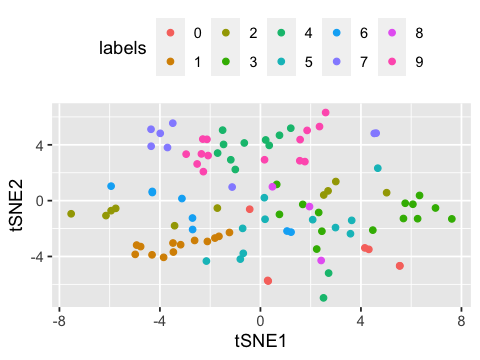

In [111]:
ggplot(Y_tsne, aes(x=tSNE1, y=tSNE2, color=labels)) +
  geom_point() +
  theme(legend.position="top")

In [84]:
library(uwot)

In [85]:
Y_umap <- umap(PCA, n_neighbors = 10, learning_rate = 0.5, init = "random")

In [86]:
Y_umap = as.data.frame(Y_umap)

In [87]:
colnames(Y_umap) <- c("UMAP1", "UMAP2")

In [92]:
Y_umap["labels"] <- Y_tsne[["labels"]]

In [93]:
summary(Y_umap)

     UMAP1             UMAP2              labels  
 Min.   :-3.9868   Min.   :-2.04408   3      :14  
 1st Qu.:-2.2271   1st Qu.:-0.59281   9      :14  
 Median : 0.4094   Median : 0.06695   1      :13  
 Mean   : 0.0000   Mean   : 0.00000   4      :12  
 3rd Qu.: 2.1520   3rd Qu.: 0.67427   5      :11  
 Max.   : 3.5372   Max.   : 1.31920   2      :10  
                                      (Other):26  

In [94]:
library(ggplot2)

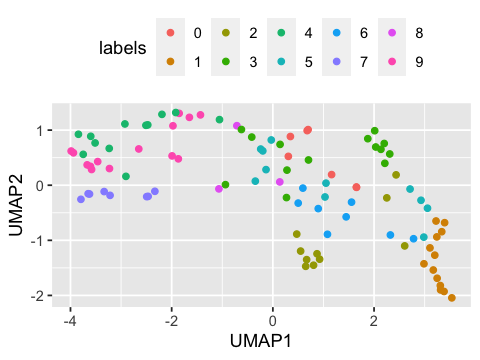

In [96]:
ggplot(Y_umap, aes(x=UMAP1, y=UMAP2, color=labels)) +
  geom_point() + 
theme(legend.position="top")

In [87]:
nums_clean <- nums[,colSums(nums)>0]

In [88]:
dim(nums_clean)

[1] 200 558

In [90]:
nums_std = apply(nums_clean, 2, function(x){(x-mean(x))/sd(x)})

In [97]:
Y_tsne <- casl_tsne(nums_std, perplexity = 30, iter=1000)

In [ ]:
plot(Y_tsne[,1],Y_tsne[,2])

In [67]:
library(dbscan)


Attaching package: ‘dbscan’


The following object is masked from ‘package:stats’:

    as.dendrogram




In [35]:
Kdist <- kNN(nums, k=5)

In [36]:
Kdist

k-nearest neighbors for 100 objects (k=5).
Available fields: dist, id, k, sort

In [37]:
kdist_id <- as.matrix(Kdist$id)

In [38]:
Kdist_D <- Kdist$dist

In [39]:
as.matrix(kdist_id)

,1,2,3,4,5
3425,6,25,88,75,74
6816,85,20,51,4,82
4458,27,12,76,59,25
2809,51,78,43,73,82
3882,20,22,78,82,71
651,1,25,88,81,77
5586,48,21,81,74,41
1904,19,9,92,64,43
1723,8,19,34,88,46
1359,95,38,39,46,100
